In [61]:
%pip install datasets transformers
%pip install Pillow
%pip install torch torchvision
%pip install scikit-learn
%pip install matplotlib seaborn pandas geopandas numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [62]:
from typing import TypedDict
import math
import os, csv

DatasetItem = TypedDict('DatasetItem', {'filename': str, 'latitude': float, 'longitude': float, 'sector': int})

files = os.listdir('./dataset/images')
files = sorted(files, key=lambda x: int(x.split('.')[0]))

with open('dataset/coords.csv', 'r', newline='') as csvfile:
    reader = csv.reader(csvfile)   
    coords = list(reader)
    coords = [[float(lat), float(lon)] for lat, lon in coords]

def sector_from_coords(lat: float, lon: float) -> int:
    norm_lat = (lat + 90) / 180
    norm_lon = (lon + 180) / 360
    # do 36 by 18 sectors
    sector = math.floor(norm_lat * 18) * 36 + math.floor(norm_lon * 36)
    return sector


with open('dataset/labels.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['filename', 'latitude', 'longitude', 'sector'])
    for file_name, coord in zip(files, coords) :
        lat, lon = coord
        sector = sector_from_coords(lat, lon)
        writer.writerow([file_name, lat, lon, sector])


Generating train split: 10000 examples [00:00, 502558.62 examples/s]


Dataset({
    features: ['filename', 'latitude', 'longitude', 'sector'],
    num_rows: 8000
})


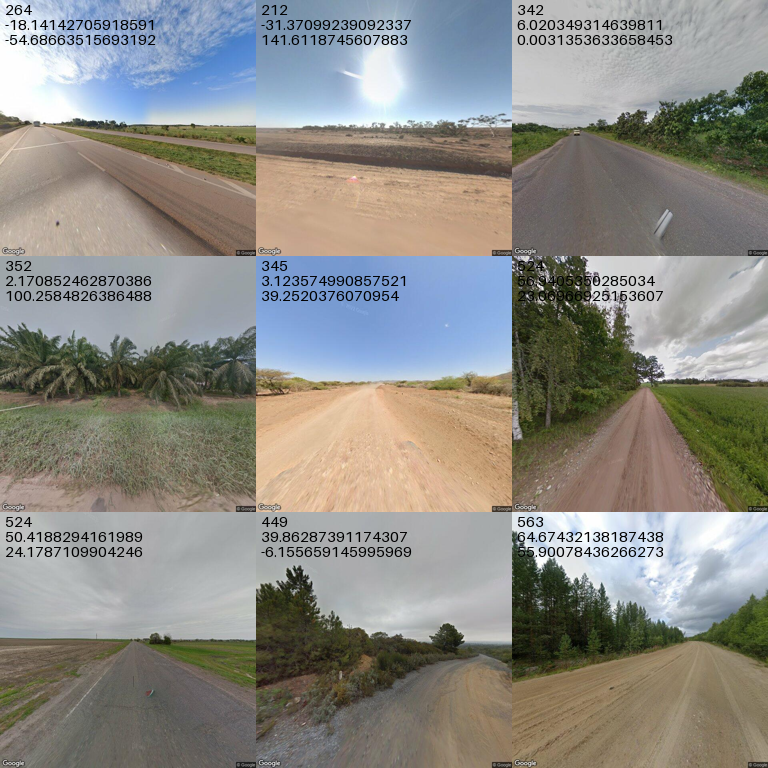

In [63]:
from datasets import load_dataset, Dataset # type: ignore
from PIL import Image, ImageDraw, ImageFont
from typing import Tuple, Set
import random

dataset = load_dataset("csv", data_files="dataset/labels.csv", split='train').train_test_split(test_size=0.2) # type: ignore
labels: List[int] = sorted(list(set(dataset["train"]["sector"] + dataset["test"]["sector"]))) # type: ignore

def path(fn: str) -> str:
    return f"./dataset/images/{fn}"

def show_examples(train: Dataset, size: Tuple[int, int]):
    w, h = size
    print(train)
    items_in_dataset = train.num_rows
    square = 3

    keys: Set[int] = set()
    count = 0 

    grid = Image.new('RGB', size=(w * square, h * square))
    font = ImageFont.load_default(size=15)
    
    while count < square * square:
        rand = random.randrange(items_in_dataset)
        if rand in keys:
            continue
        keys.add(rand)

        item: DatasetItem = train[rand] # type: ignore
        file_name = item["filename"]
        image = Image.open(path(file_name)) # type: ignore
        x = count % square
        y = count // square
        grid.paste(image.resize((w, h)), (x * w, y * h)) # type: ignore
        draw = ImageDraw.Draw(grid) # type: ignore

        sector = item["sector"]
        lat = item["latitude"]
        lon = item["longitude"]

        draw.text((x * w + 5 , y * h), str(sector), font=font, fill=(0,0,0)) # type: ignore
        draw.text((x * w + 5, y * h + 15), str(lat), font=font, fill=(0,0,0)) # type: ignore
        draw.text((x * w + 5, y * h + 30), str(lon), font=font, fill=(0,0,0)) # type: ignore
        count += 1
        
    return grid

show_examples(dataset["train"], size=(256, 256)) # type: ignore

/var/folders/90/yrhw4ptx6t1570jt9d38zmqw0000gn/T/ipykernel_76892/1930603399.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


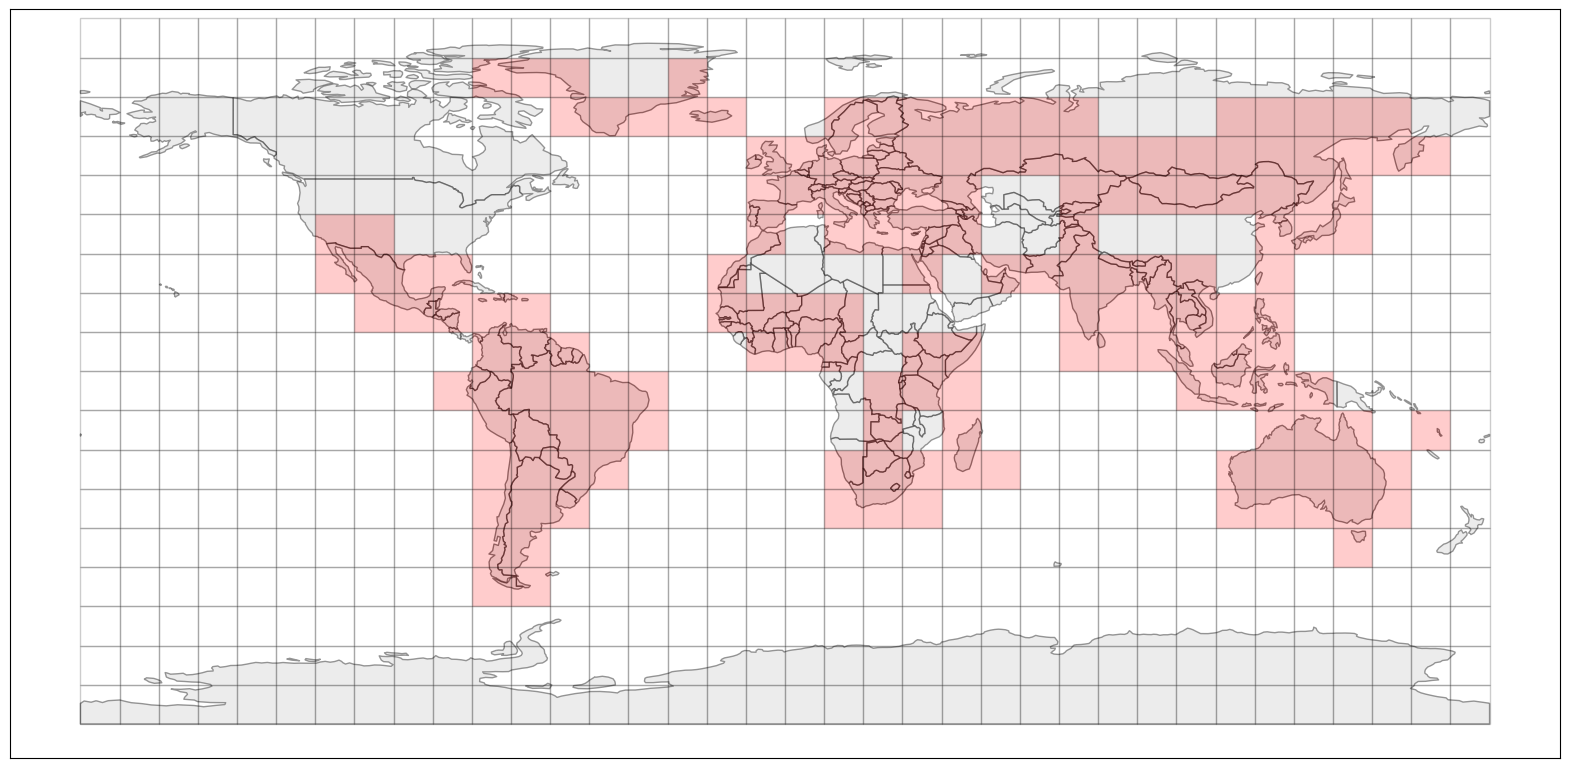

In [86]:
# type: ignore

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import geopandas as gpd

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

world.plot(
    ax=ax,
    color="lightgray",
    edgecolor="black",
    alpha=0.5
)

for sector in range(36 * 18):
    x, y = (sector % 36) * 10, (sector // 36) * 10
    rect = patches.Rectangle((x - 180, y - 90), 10, 10, linewidth=1, edgecolor='black', facecolor='red' if sector in labels else "white", alpha=0.2)
    ax.add_patch(rect)

# turn off axis ticks
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [65]:
from transformers import ViTImageProcessor # type: ignore

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path) # type: ignore

In [66]:
# type: ignore
from PIL import Image
from typing import List

def transform(batch: List[DatasetItem]):
    inputs = processor([Image.open(path(x)) for x in batch['filename']], return_tensors='pt')
    labels = list(set(batch['sector']))
    inputs['labels'] = labels
    print(inputs['labels'])
    return inputs

prepared_dataset = dataset.with_transform(transform)

In [67]:
# type: ignore

import numpy as np
from datasets import load_metric 
from transformers import BatchFeature
import torch

def collate_fn(batch: List[BatchFeature]):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }


metric = load_metric("accuracy")

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

/Users/flatypus/Documents/LukaBot/.venv/lib/python3.11/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [68]:
# type: ignore

from transformers import ViTForImageClassification

labels = dataset['train'].unique('sector')

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Flattening the indices: 100%|██████████| 8000/8000 [00:00<00:00, 41336.22 examples/s]
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
